In [11]:
import pandas as pd
import os 
from pathlib import Path
from bertopic import BERTopic
import re 
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
import plotly.io as pio

import pandas as pd
import os 
from pathlib import Path
from nltk.corpus import stopwords

from preprocessing.preprocessing_module import full_cleaning_pipeline


metaproject_name = 'TopicModelling_META'
subproject_name = 'TopMod_pipeline'
# dataset_name = f'{condition}_dataset.csv'


DATASET_NAME = "Handwritten_CombinedTranslation.csv"
HIGH_SENSORY = True #If False, corresponds to deep listening experience (no flicker)
CONDITION = 'highsensory' if HIGH_SENSORY else 'deeplistening'
print(f'Condition : "{CONDITION}"')




PROJDIR = os.path.expanduser(f"~/projects/{metaproject_name}")
DATADIR = os.path.join(PROJDIR,f'DATA/{dataset_name}')
CODEDIR = os.path.join(PROJDIR,f'{subproject_name}')



%matplotlib inline

Condition : "highsensory"


Parameters for BERTopic

https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html

In [43]:
from transformers.pipelines import pipeline

#Parameters for Topic Modelling
remove_stopwords = True
extended_stopwords = False

embedding_model = "all-MiniLM-L6-v2" #which transformer-based model to use to create embeddings of the reports
# embedding_model = pipeline("feature-extraction", model="distilbert-base-cased")
# topic_model = BERTopic(embedding_model=embedding_model)
min_topic_size = 20 #sets the minimum number of reports that a topic should have. If set to None ==> run the optimal nb function



Import Data

In [44]:
df = pd.read_csv(DATADIR)
dataset = df['reflection_answer']
reports = dataset[dataset.notna() & (dataset != '')].reset_index(drop=True) #delete empty rows
reports = pd.DataFrame(reports)
reports

,reflection_answer
0,Felt like how I feel in the split second befor...
1,"Surreal\nConnection to other dimension, in a g..."
2,"\r\nDrifted into different stories, saw intens..."
3,"At the session start, I could only see orange ..."
4,Patterns were the main ‘visual’ when my eyes w...
...,...
3657,"I had a brief, very tangible experience, a vis..."
3658,I could see fractal patterns like I was in a k...
3659,"Vivid waves , transportation at speed from sun..."
3660,Felt a connection with the subconscious mind. ...


In [45]:
#check if preprocessed dataset already exist, and if not, create a preprocessed dataset and store it in the preprocessing folder

base_name, ext = os.path.splitext(DATASET_NAME)
new_path = f"{base_name}_{CONDITION}_preprocessed{ext}"
preproc_path = os.path.join(PROJDIR, f'DATA/preprocessed/{new_path}')

# Check if the preprocessed file already exists
if not os.path.exists(preproc_path):
    # If not, create it using the full_cleaning_pipeline function and save it
    reports = full_cleaning_pipeline(reports, 'reflection_answer')
    reports = reports.reset_index(drop=True)
    
    # Ensure the directory exists before saving the file
    os.makedirs(os.path.dirname(preproc_path), exist_ok=True)
    
    reports.to_csv(preproc_path, index=False)
else:
    print(f"The preprocessed file already exists at: {preproc_path}")


print('N={} reports (HighSensory = {})'.format(len(reports),HIGH_SENSORY))
reports.head()

The preprocessed file already exists at: /Users/rb666/projects/TopicModelling_META/DATA/preprocessed/Handwritten_CombinedTranslation_highsensory_preprocessed.csv
N=3662 reports (HighSensory = True)


,reflection_answer
0,Felt like how I feel in the split second befor...
1,"Surreal\nConnection to other dimension, in a g..."
2,"\r\nDrifted into different stories, saw intens..."
3,"At the session start, I could only see orange ..."
4,Patterns were the main ‘visual’ when my eyes w...


In [46]:
print('N={} reports (HighSensory = {})'.format(len(reports),HIGH_SENSORY))
reports.head()

N=3662 reports (HighSensory = True)


,reflection_answer
0,Felt like how I feel in the split second befor...
1,"Surreal\nConnection to other dimension, in a g..."
2,"\r\nDrifted into different stories, saw intens..."
3,"At the session start, I could only see orange ..."
4,Patterns were the main ‘visual’ when my eyes w...


## BERTopic

https://miro.medium.com/v2/resize:fit:4800/format:webp/0*DxAqCqx6dzg0KQlg.png

In [47]:
# finds the maximum min_topic_size that doesn't cause an error

def find_max_topics(data, embedding_model, min_topic_size_range):
    max_topics = 0
    optimal_min_topic_size = 0
    
    for min_size in min_topic_size_range:
        try:
            model = BERTopic(language="english", 
                             calculate_probabilities=True, 
                             verbose=True,
                             nr_topics='auto',
                             embedding_model=embedding_model,
                             min_topic_size=min_size)
            
            topics, _ = model.fit_transform(data)
            num_topics = len(set(topics))  # Calculate the number of unique topics
            
            if num_topics > max_topics:
                max_topics = num_topics
                optimal_min_topic_size = min_size
                
            print(f"Min_topic_size: {min_size}, Num Topics: {num_topics}")
            
        except ValueError as e:
            print(f"Error with min_topic_size: {min_size}. Error message: {str(e)}")
            continue
        
    return max_topics, optimal_min_topic_size




min_topic_size_range = range(10, 1, -1)  # Adjust the range as per your requirement
data = reports['reflection_answer']

if not min_topic_size:
    max_topics, optimal_min_topic_size = find_max_topics(data, embedding_model, min_topic_size_range)
    print(f"Maximum number of topics: {max_topics} found with min_topic_size: {optimal_min_topic_size}")
else:
    optimal_min_topic_size = min_topic_size

print(optimal_min_topic_size)


20


### Training the BERT model

In [48]:
from bertopic import BERTopic

model = BERTopic(language="english", calculate_probabilities=True, verbose=True,nr_topics='auto',embedding_model=embedding_model,min_topic_size=optimal_min_topic_size) #The higher the value of min_topic_size, the more specific the topics will be
topics, probs = model.fit_transform(reports['reflection_answer']) #Fit model to data : topics are the topic labels for each document, probs are the probabilities of each topic for each document
model.visualize_topics() #Visualize topics


Batches:   0%|          | 0/115 [00:00<?, ?it/s]

2023-10-10 12:41:07,368 - BERTopic - Transformed documents to Embeddings
2023-10-10 12:41:14,968 - BERTopic - Reduced dimensionality
2023-10-10 12:41:15,126 - BERTopic - Clustered reduced embeddings
2023-10-10 12:41:15,371 - BERTopic - Reduced number of topics from 15 to 15


### Topic extraction and representation

In [49]:
topic_freq = model.get_topic_freq().head() #Get the frequency of each topic
freq = model.get_topic_info() #see the most representative terms for each topic
print("N number of topics: ",len(freq))
print(freq.head())


N number of topics:  15
   Topic  Count                     Name  \
0     -1   2036        -1_the_of_and_was   
1      0    448       0_the_music_and_to   
2      1    409  1_of_shapes_and_colours   
3      2    112        2_and_felt_the_to   
4      3     99        3_the_felt_and_to   

                                      Representation  \
0    [the, of, and, was, in, to, it, like, felt, my]   
1  [the, music, and, to, was, of, it, in, experie...   
2  [of, shapes, and, colours, blue, patterns, the...   
3  [and, felt, the, to, of, was, it, like, time, my]   
4  [the, felt, and, to, it, was, experience, of, ...   

                                 Representative_Docs  
0  [Felt like I was being born and discovering al...  
1  [The music became very visual as I listened. T...  
2  [I saw slowly changing colours & shapes, some ...  
3  [I saw purple, orange and flickering images of...  
4  [I really enjoyed the experience I would like ...  


## Prileminary visualisation

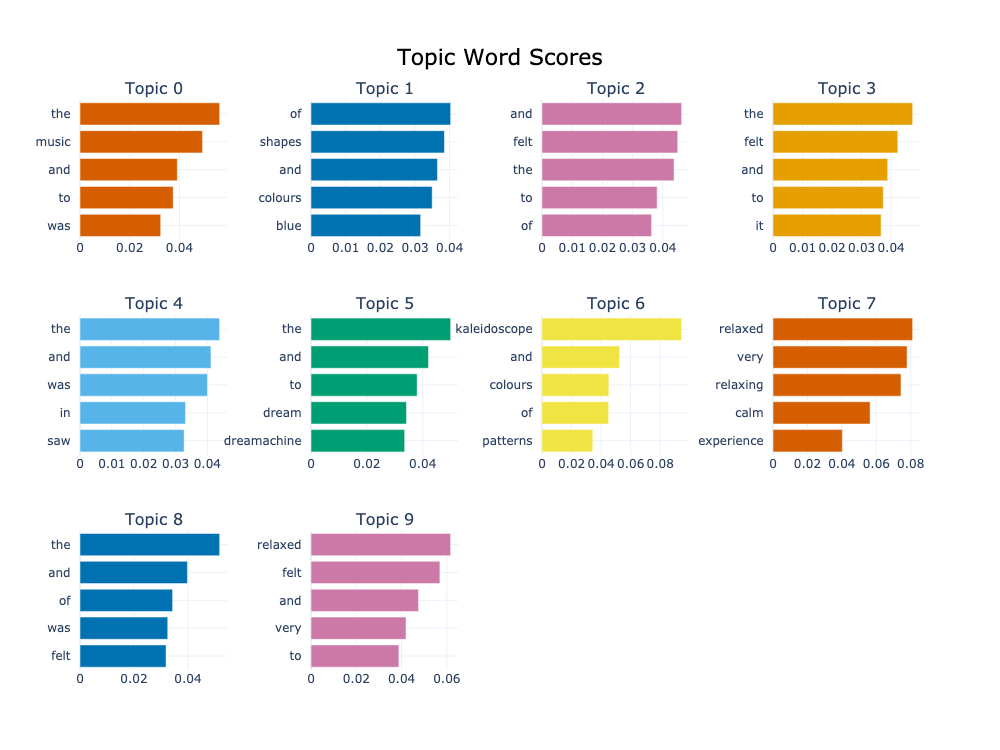

In [50]:
outputs_path = os.path.join(CODEDIR,'BERT_outputs')

# Save the barchart visualization to a file
fig = model.visualize_barchart(top_n_topics=10) #Visualize the top 10 topics
save_path_barchart = os.path.join(outputs_path,'BERT_barchart.png')
fig.write_image(save_path_barchart)

# # Import the Image and display functions from IPython
# from IPython.display import Image, display

# Display the saved image
display(Image(filename=save_path_barchart))

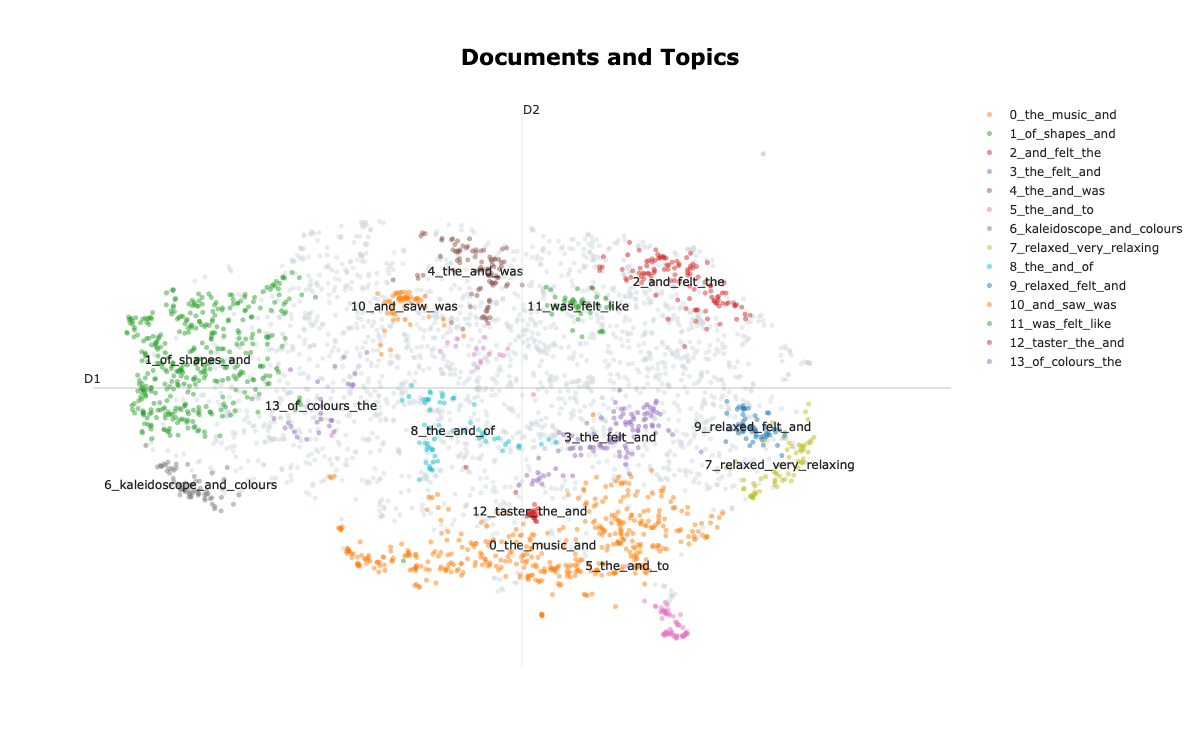

In [51]:
# Save the barchart visualization to a file
fig = model.visualize_documents(reports['reflection_answer'])
save_path_cloud = os.path.join(outputs_path,'BERT_cloud_{}.png'.format(CONDITION))
fig.write_image(save_path_cloud)

# # Import the Image and display functions from IPython
# from IPython.display import Image, display

# Display the saved image
display(Image(filename=save_path_cloud))

In [42]:
model.visualize_heatmap(top_n_topics=10) #Visualize the top 10 topics as a heatmap